In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import minimize
import glob
import os
import sys
import time
from datetime import datetime

from lsst.all_sky_phot.wcs import wcs_zea, wcs_refine_zea, Fisheye, load_fisheye, distortion_mapper, distortion_mapper_looper
from lsst.all_sky_phot import phot_night, readcr2, readYBC, radec2altaz, star2altaz, phot_image, default_phot_params

from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, Longitude, Latitude
import astropy.units as u
from astropy.time import Time, TimezoneInfo
from astropy.table import Table, vstack
from astropy import units as u

from photutils import CircularAperture

from scipy.spatial import KDTree
import healpy as hp
from lsst.sims.utils import healbin

In [19]:
rough_wcs = load_fisheye('initial_wcs.npz')
initial_wcs = rough_wcs.wcs

In [5]:
# load up a g image
filename = '2018-02-05/2018_02_05__20_10_26.fits'
hdul = fits.open(filename)
image = hdul[0].data.copy()
header = hdul[0].header.copy()
hdul.close()

In [13]:
utc_offset = 7/24. # in days.
lat = Latitude(header['SITELAT'][:-3], unit=u.deg)
lon = Longitude(header['SITELONG'][:-3], unit=u.deg)
elevation = 0.728  #km
PI_backyard = EarthLocation(lat=lat, lon=lon, height=elevation*u.km)

In [6]:
ybc = readYBC()

In [41]:
# Set photometry paramters
phot_params = default_phot_params()
phot_params['dao_fwhm'] = 2.0
phot_params['dao_thresh'] = 6.
phot_table = phot_image(image, phot_params=phot_params)

In [42]:
phot_appertures = CircularAperture( (phot_table['xcenter'], phot_table['ycenter']), r=5.)
# guess the camera zeropoint
zp = -18.
measured_mags = -2.5*np.log10(phot_table['residual_aperture_sum'].data) - zp

In [43]:
# Calc where we expect stars
date_string = header['DATE-OBS']
time_obj = Time(date_string, scale='utc')
mjd = time_obj.mjd+utc_offset
alt_cat, az_cat = radec2altaz(ybc['RA'], ybc['Dec'], mjd, location=PI_backyard)
above = np.where(alt_cat > 5.)
x_expected, y_expected = initial_wcs.all_world2pix(az_cat[above], alt_cat[above], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:643: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:643: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:526: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:526: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/pyt

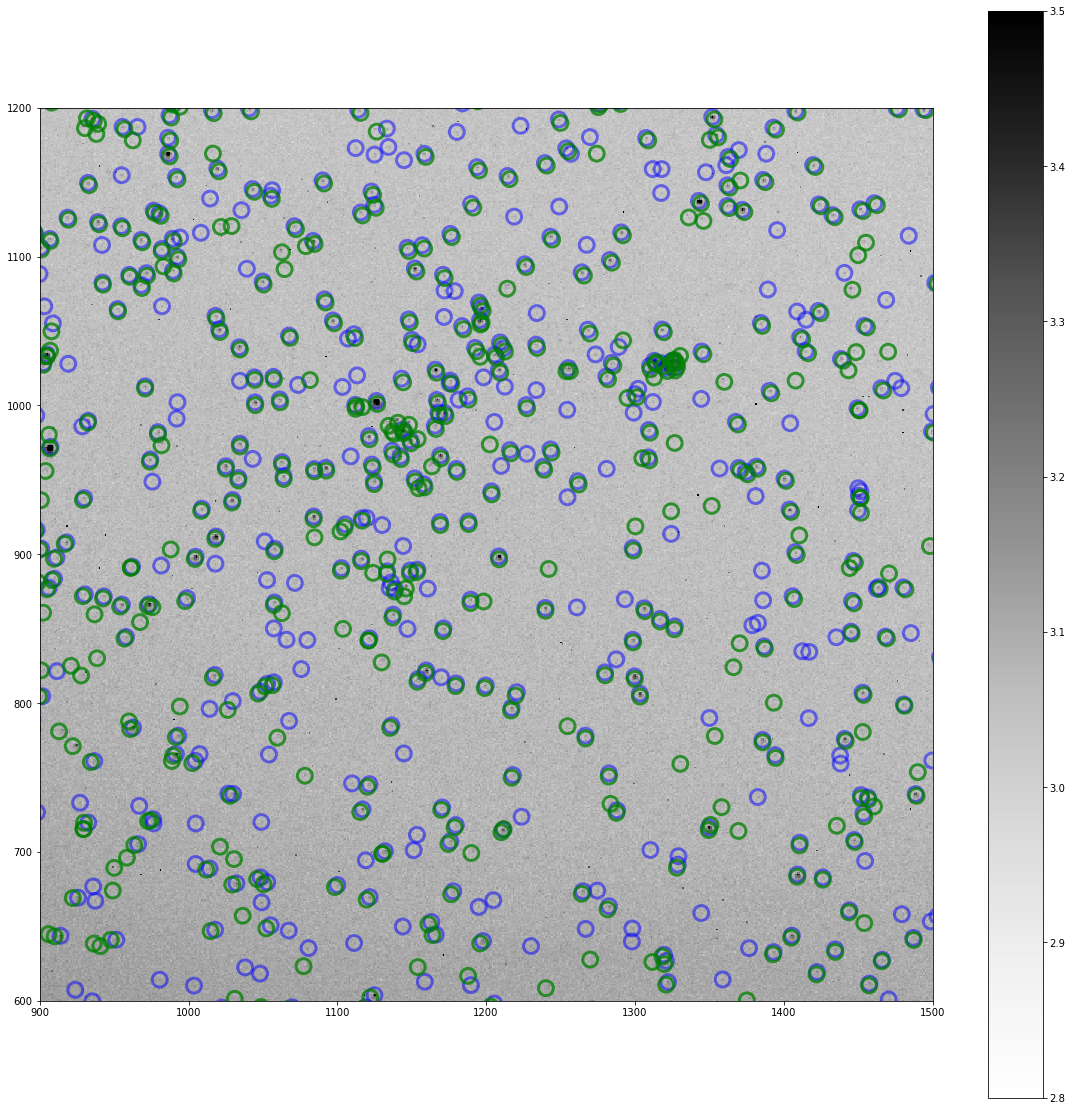

In [98]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=2.8, vmax=3.5)
plt.colorbar()
plt.xlim([900, 1500])
plt.ylim([600,1200])
# Detected objects in blue
phot_appertures.plot(color='blue', lw=3, alpha=0.5)
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.75)

In [100]:
phot_inbox = np.where((phot_table['xcenter'].value > 900) & (phot_table['xcenter'].value < 1500) & 
                 (phot_table['ycenter'].value > 600) & (phot_table['ycenter'].value < 1200))
predicted_inbox = np.where( (x_expected > 900) & (x_expected < 1500) 
                          & (y_expected > 600) & (y_expected < 1200))

In [101]:
# ok, Yale bright star catalog x,y positions are in x_expected, y_expected. And mags are in ybc['Vmag'].values[above]
# detected x,y in phot_table['xcenter'], phot_table['ycenter']
phot_tree = KDTree(list(zip(phot_table['xcenter'].value[phot_inbox], phot_table['ycenter'].value[phot_inbox])))
# Compute the distance to the nearest neighbor for each star
distances, indices = phot_tree.query(np.array((x_expected[predicted_inbox], y_expected[predicted_inbox])).T)

In [115]:
# I guess I could match this the other way... demand a detection within 3 pix, and X mag. 
# Then I can plot the catalog and the detected stars.

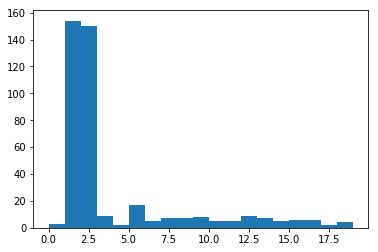

In [102]:
bins = np.arange(20)
ack = plt.hist(distances, bins=bins)

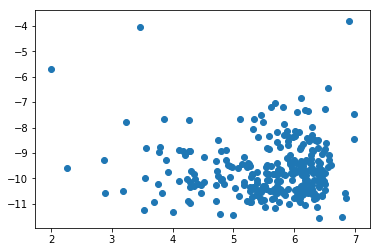

In [103]:
close_limit = 2.5
close = np.where(distances < close_limit)
plt.scatter(ybc['Vmag'].values[predicted_inbox][close], -2.5*np.log10(phot_table['residual_aperture_sum'].data[indices][close]))

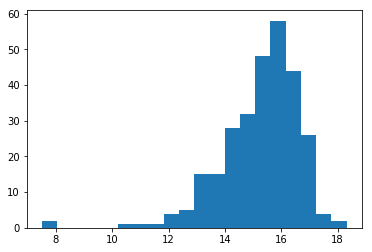

In [104]:
ack = plt.hist(ybc['Vmag'].values[predicted_inbox][close]+2.5*np.log10(phot_table['residual_aperture_sum'].data[indices][close]),
              bins=20)

new_zp = np.median(ybc['Vmag'].values[predicted_inbox][close]+2.5*np.log10(phot_table['residual_aperture_sum'].data[indices][close]))

In [105]:
new_zp

15.501414394437116

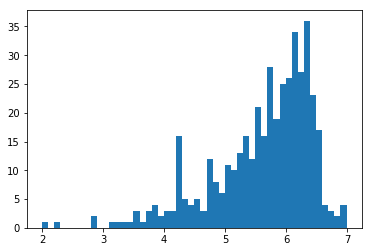

In [106]:
ack = plt.hist(ybc['Vmag'].values[predicted_inbox], bins=50)

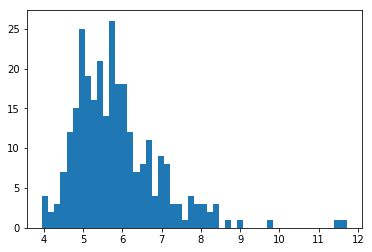

In [107]:
ack = plt.hist(-2.5*np.log10(phot_table['residual_aperture_sum'].data[indices][close])+new_zp, bins=50)

In [109]:
cumulative_catalog = np.arange(ybc['Vmag'].values[predicted_inbox].size)
x_catalog = np.sort(ybc['Vmag'].values[predicted_inbox])

x_obs = np.sort(-2.5*np.log10(phot_table['residual_aperture_sum'].data[indices][close])+new_zp)
cumulative_matched = np.arange(x_obs.size)

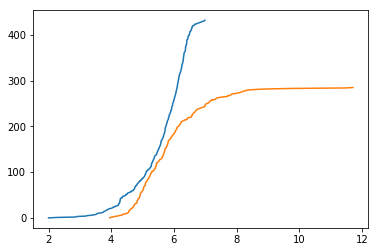

In [110]:
plt.plot(x_catalog, cumulative_catalog)
plt.plot(x_obs, cumulative_matched)

In [114]:
predicted_inbox[0].size, close[0].size

(433, 286)